<a href="https://colab.research.google.com/github/Lokeshgadhi/introonpandas/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [8]:
import pandas as pd

# Step 1: Load and clean
df = pd.read_csv("exchange_rate.csv", encoding='utf-8-sig')
df.columns = df.columns.str.strip()
print("Columns found:", df.columns.tolist())

# Step 2: Rename
df.rename(columns={"Ex_rate": "USD_to_AUD"}, inplace=True)

# Step 3: Parse date and set index
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df.set_index("date", inplace=True)

# Step 4: Resample to daily frequency
df = df.asfreq("D")

# Step 5: Preview
print(df.head())


Columns found: ['date', 'Ex_rate']
            USD_to_AUD
date                  
1990-01-01      0.7855
1990-01-02      0.7818
1990-01-03      0.7867
1990-01-04      0.7860
1990-01-05      0.7849


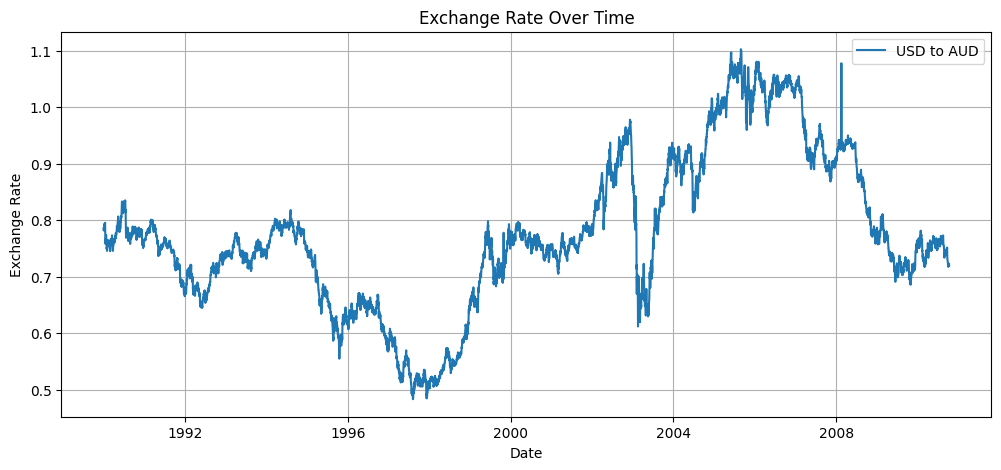

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(df["USD_to_AUD"], label='USD to AUD')
plt.title("Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
df["USD_to_AUD"] = df["USD_to_AUD"].interpolate(method='time')  # Time-based interpolation


In [11]:
result = adfuller(df["USD_to_AUD"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


In [12]:
if result[1] > 0.05:
    d = 1
    ts_diff = df["USD_to_AUD"].diff().dropna()
else:
    d = 0
    ts_diff = df["USD_to_AUD"]


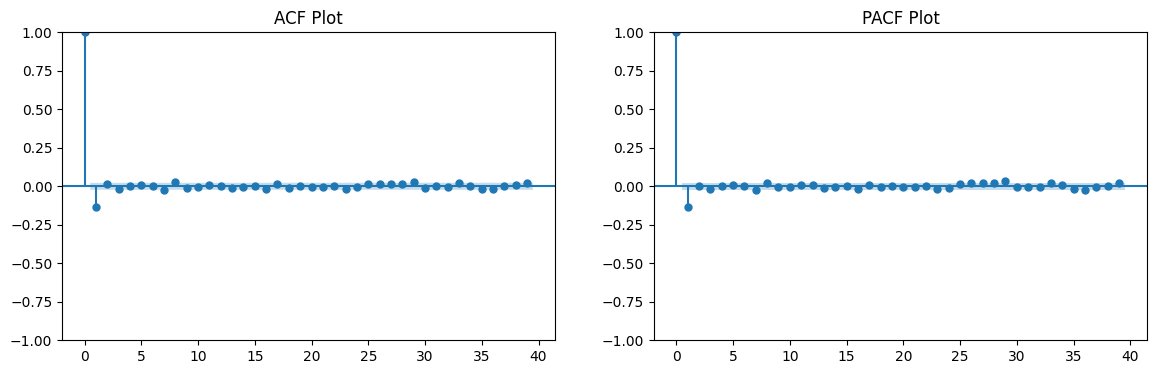

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.show()


In [14]:
p, q = 1, 1  # Adjust as needed
arima_model = ARIMA(df["USD_to_AUD"], order=(p, d, q))
arima_fit = arima_model.fit()
print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             USD_to_AUD   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 16 Jun 2025   AIC                         -56102.322
Time:                        16:36:09   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

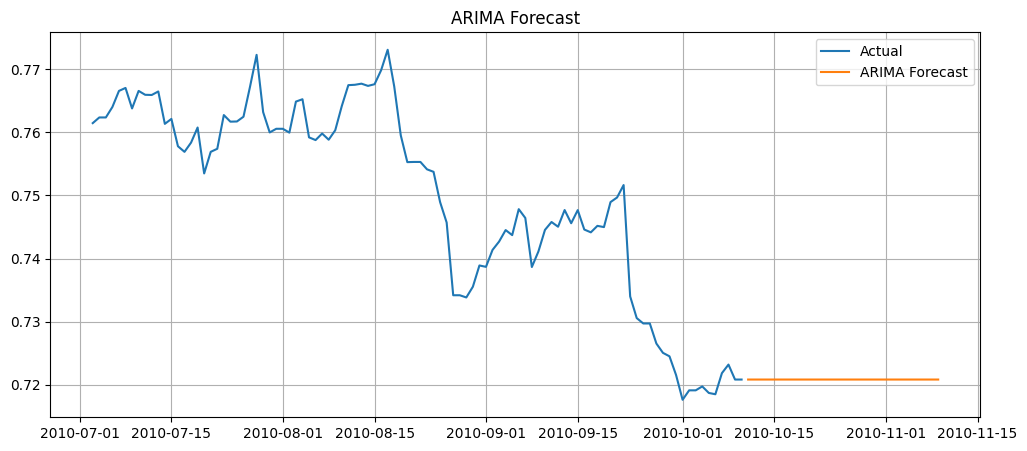

In [15]:
forecast_steps = 30
arima_forecast = arima_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 5))
plt.plot(df["USD_to_AUD"].iloc[-100:], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:], arima_forecast, label='ARIMA Forecast')
plt.title("ARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()


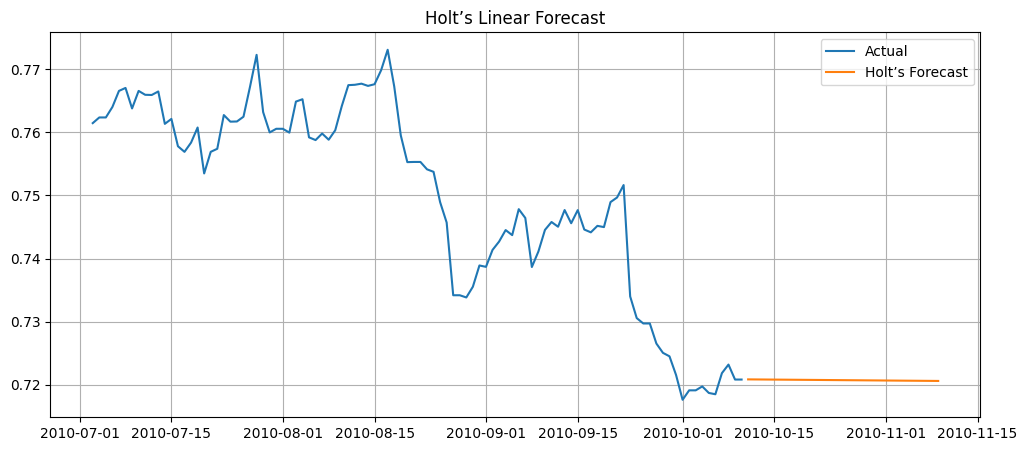

In [16]:
hw_model = ExponentialSmoothing(df["USD_to_AUD"], trend='add', seasonal=None)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(forecast_steps)

plt.figure(figsize=(12, 5))
plt.plot(df["USD_to_AUD"].iloc[-100:], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:], hw_forecast, label="Holt’s Forecast")
plt.title("Holt’s Linear Forecast")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
test_size = 30
train = df["USD_to_AUD"][:-test_size]
test = df["USD_to_AUD"][-test_size:]

# Refit ARIMA and Holt's
arima_fit_train = ARIMA(train, order=(p, d, q)).fit()
arima_pred = arima_fit_train.forecast(steps=test_size)

hw_fit_train = ExponentialSmoothing(train, trend='add').fit()
hw_pred = hw_fit_train.forecast(steps=test_size)


In [18]:
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

evaluate(test, arima_pred, "ARIMA")
evaluate(test, hw_pred, "Holt’s Linear")


ARIMA - MAE: 0.0135, RMSE: 0.0166, MAPE: 1.86%
Holt’s Linear - MAE: 0.0134, RMSE: 0.0165, MAPE: 1.85%


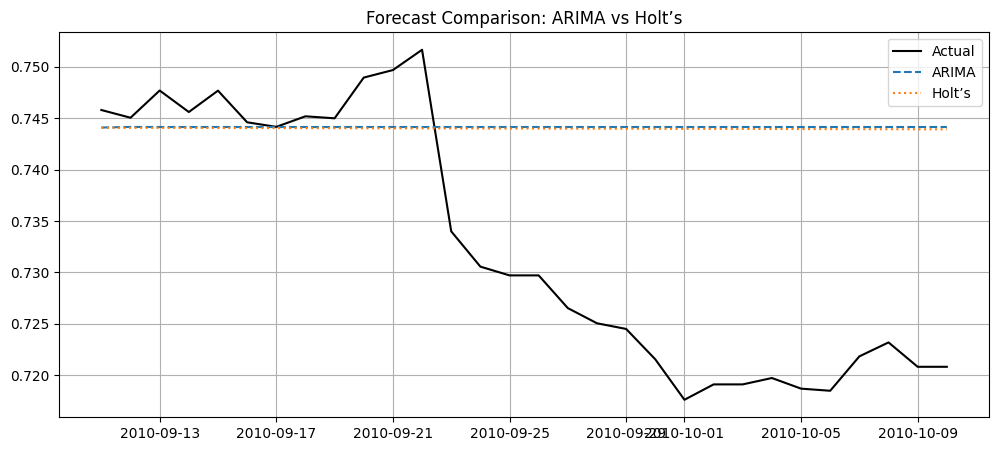

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, arima_pred, label='ARIMA', linestyle='--')
plt.plot(test.index, hw_pred, label="Holt’s", linestyle='dotted')
plt.title("Forecast Comparison: ARIMA vs Holt’s")
plt.legend()
plt.grid(True)
plt.show()
